In [1]:
import os

import numpy as np
from scipy.stats import sem
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import SR_IS_NHB, SR_NHB, MB_NHB, Hybrid_NHB
from utils import policy_reval, woodbury
from utils_render import create_bar_plot, plot_nhb_decisions

In [2]:
# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [4]:
## Hyperparameters for direct NHB comparison
set_val = 5
lr = 0.05
lambd = set_val
lambd_test = set_val
alpha = lr
alpha_SR = lr
beta_SR_IS = set_val
beta_SR = set_val
temp_SR_IS = set_val
temp_SR = set_val
num_steps = 250
num_iterations = 800

In [5]:
def softmax(logits, temp=1.0):
    """softmax function for action selection"""
    exp_logits = np.exp(logits / temp - np.max(logits / temp))
    return exp_logits / np.sum(exp_logits)

# Policy Revaluation

## Run Simulations

### Complete Model

In [6]:
probs_complete, probs_mb = [], []
num_switch_complete, num_switch_mb = [], []
number = 0

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_MB = MB_NHB(beta=beta_SR, policy="softmax", exp_type="policy_reval")
    
    ##  Linear RL  ##
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=temp_SR_IS) 
    dec_train = np.random.choice(len(probs), p=probs)

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)
    
    ##  MB  ##
    agent_MB.update_V()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    dec_train = np.random.choice(len(probs), p=probs)
    
    agent_MB.update_exp()
    agent_MB.update_V()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    probs_mb.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    
    if dec_train == 1:
        if dec_test == 0:
            num_switch_mb.append(1)
        else:
            num_switch_mb.append(0)

### TD Models

In [7]:
probs_sr, probs_sr_is, probs_hybrid = [], [], []
num_switch_sr, num_switch_sr_is, num_switch_hybrid = [],[], []
probs_train, probs_test = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_SR_IS = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="policy_reval")
    agent_Hybrid = Hybrid_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Learn similarly to NHB
    agent_SR_IS.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)
    agent_Hybrid.learn_with_start_locs(seed=i)

    ##  SR  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)

    ##  SR-IS  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR_IS.V[1], agent_SR_IS.V[2]]), temp=temp_SR_IS)
    probs_train.append(probs)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR_IS.update_exp()
    # Change lambda to 1 at test
    agent_SR_IS._lambda = lambd_test
    V_new, Z_new = policy_reval(agent_SR_IS)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_test.append(probs)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)
    
    ##  HYBRID  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_Hybrid.update_exp()
    agent_Hybrid.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    probs_hybrid.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_hybrid.append(1)
        else:
            num_switch_hybrid.append(0)

## Action Selection Probs

In [8]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)
num_mb = np.array(num_switch_mb)
num_hybrid = np.array(num_switch_hybrid)

# mean_policy_complete = np.mean(num_complete)
# mean_policy_sr = np.mean(num_sr)
# mean_policy_sr_is = np.mean(num_sr_is)

print("Complete: ",np.mean(num_complete), " SR: ", np.mean(num_sr), " SR-IS: ", np.mean(num_sr_is), "MB: ", np.mean(num_mb), "Hybrid: ", np.mean(num_hybrid))

Complete:  0.9526938239159002  SR:  0.1906158357771261  SR-IS:  0.7779237844940867 MB:  0.9490861618798956 Hybrid:  0.6557377049180327


In [9]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)
probs_mb = np.array(probs_mb)
probs_hybrid = np.array(probs_hybrid)

mean_policy_complete = np.mean(probs_complete)
mean_policy_sr = np.mean(probs_sr)
mean_policy_sr_is = np.mean(probs_sr_is)
mean_policy_mb = np.mean(probs_mb)
mean_policy_hybrid = np.mean(probs_hybrid)

sem_policy_complete = sem(probs_complete)
sem_policy_sr = sem(probs_sr)
sem_policy_sr_is = sem(probs_sr_is)
sem_policy_mb = sem(probs_mb)
sem_policy_hybrid = sem(probs_hybrid)

print("Complete: ", (mean_policy_complete, sem_policy_complete), 
      " SR: ", (mean_policy_sr, sem_policy_sr), 
      " SR-IS: ", (mean_policy_sr_is, sem_policy_sr_is),
      "\nMB: ", (mean_policy_mb, sem_policy_mb),
      " Hybrid: ", (mean_policy_hybrid, sem_policy_hybrid))

Complete:  (0.9504469405235371, 7.8553734370293e-18)  SR:  (0.17329077185161368, 0.002914919860800514)  SR-IS:  (0.7802160708767957, 0.008112041009767498) 
MB:  (0.9525741268224336, 7.8553734370293e-18)  Hybrid:  (0.6593808582561184, 0.0020588802606681393)


In [10]:
stacked_train = np.stack(probs_train)
mean_policy_train = np.mean(stacked_train, axis=0)
sem_policy_train = sem(stacked_train, axis=0)

stacked_test = np.stack(probs_test)
mean_policy_test = np.mean(stacked_test, axis=0)
sem_policy_test = sem(stacked_test, axis=0)

print("Train: ", (mean_policy_train, sem_policy_train), " Test: ", (mean_policy_test, sem_policy_test))

Train:  (array([0.0578133, 0.9421867]), array([0.00024083, 0.00024083]))  Test:  (array([0.78021607, 0.21978393]), array([0.00811204, 0.00811204]))


# Reward Revaluation

## Run Simulations

### Complete Model

In [11]:
probs_complete, probs_mb = [], []
num_switch_complete, num_switch_mb = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_MB = MB_NHB(beta=beta_SR, policy="softmax", exp_type="reward_reval")
    
    ##  Linear RL  ##
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=temp_SR_IS) 
    dec_train = np.random.choice(len(probs), p=probs)


    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)
    
    ##  MB  ##
    agent_MB.update_V()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    dec_train = np.random.choice(len(probs), p=probs)
    
    agent_MB.update_exp()
    agent_MB.update_V()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    probs_mb.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    
    if dec_train == 1:
        if dec_test == 0:
            num_switch_mb.append(1)
        else:
            num_switch_mb.append(0)

### TD Models

In [12]:
probs_sr, probs_sr_is, probs_hybrid = [], [], []
num_switch_sr, num_switch_sr_is, num_switch_hybrid = [], [], []
probs_train, probs_test = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_SR_IS = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="reward_reval")
    agent_Hybrid = Hybrid_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Learn similar to NHB
    agent_SR_IS.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)
    agent_Hybrid.learn_with_start_locs(seed=i)

    ##  SR  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)
    
    ##  SR-IS  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_SR_IS.V[1], agent_SR_IS.V[2]]), temp=temp_SR_IS)
    probs_train.append(probs)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_SR_IS.update_exp()
    V_new, Z_new = policy_reval(agent_SR_IS)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_test.append(probs)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)
    
    ##  HYBRID  ##
    # Original training policy
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)
    # Policy revaluation
    agent_Hybrid.update_exp()
    agent_Hybrid.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    probs_hybrid.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    if dec_train == 1:
        if dec_test == 0:
            num_switch_hybrid.append(1)
        else:
            num_switch_hybrid.append(0)

## Action Selection Probs

In [13]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)
num_mb = np.array(num_switch_mb)
num_hybrid = np.array(num_switch_hybrid)

print(f"Complete: {np.mean(num_complete)} SR: {np.mean(num_sr)} SR-IS: {np.mean(num_sr_is)} MB: {np.mean(num_mb)} Hybrid: {np.mean(num_hybrid)}")

Complete: 0.9537648612945839 SR: 0.6031746031746031 SR-IS: 0.8839050131926122 MB: 0.9490861618798956 Hybrid: 0.84375


In [14]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)
probs_mb = np.array(probs_mb)
probs_hybrid = np.array(probs_hybrid)

mean_reward_complete = np.mean(probs_complete)
mean_reward_sr = np.mean(probs_sr)
mean_reward_sr_is = np.mean(probs_sr_is)
mean_reward_mb = np.mean(probs_mb)
mean_reward_hybrid = np.mean(probs_hybrid)

sem_reward_complete = sem(probs_complete)
sem_reward_sr = sem(probs_sr)
sem_reward_sr_is = sem(probs_sr_is)
sem_reward_mb = sem(probs_mb)
sem_reward_hybrid = sem(probs_hybrid)

print("Complete: ", (mean_reward_complete, sem_reward_complete), 
      " SR: ", (mean_reward_sr, sem_reward_sr), 
      " SR-IS: ", (mean_reward_sr_is, sem_reward_sr_is),
      "\nMB: ", (mean_reward_mb, sem_reward_mb),
      " Hybrid: ", (mean_reward_hybrid, sem_reward_hybrid))

Complete:  (0.9524677453332921, 7.8553734370293e-18)  SR:  (0.5773181226679778, 0.006436059927394807)  SR-IS:  (0.8807958169926985, 0.0012011055137998142) 
MB:  (0.9525741268224336, 7.8553734370293e-18)  Hybrid:  (0.8359661900360326, 0.0019743605762173318)


In [15]:
stacked_train = np.stack(probs_train)
mean_reward_train = np.mean(stacked_train, axis=0)
sem_reward_train = sem(stacked_train, axis=0)

stacked_test = np.stack(probs_test)
mean_reward_test = np.mean(stacked_test, axis=0)
sem_reward_test = sem(stacked_test, axis=0)

print("Train: ", (mean_reward_train, sem_reward_train), " Test: ", (mean_reward_test, sem_reward_test))

Train:  (array([0.06045246, 0.93954754]), array([0.00025451, 0.00025451]))  Test:  (array([0.88079582, 0.11920418]), array([0.00120111, 0.00120111]))


# Transition Revaluation

## Run Simulations

### Complete Model

In [16]:
probs_complete, probs_mb = [], []
num_switch_complete, num_switch_mb = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_MB = MB_NHB(beta=beta_SR, policy="softmax", exp_type="reward_reval")
    
    ##  Linear RL  ##
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    probs = softmax(logits=np.array([agent_complete.V[1], agent_complete.V[2]]), temp=temp_SR_IS) 
    dec_train = np.random.choice(len(probs), p=probs)

    # Update terminal state values
    T_new = agent_complete.construct_T_new()
    D_new = woodbury(agent=agent_complete, T=T_new, inv=False)
    agent_complete.DR = D_new
    agent_complete.update_Z()
    agent_complete.update_V()
    V_new = agent_complete.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_complete.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_complete.append(1)
        else:
            num_switch_complete.append(0)
        
    ##  MB  ##
    agent_MB.update_V()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    dec_train = np.random.choice(len(probs), p=probs)
    
    agent_MB.learn_trans_reval()
    probs = softmax(logits=np.array([agent_MB.V[1], agent_MB.V[2]]), temp=temp_SR) 
    probs_mb.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)
    
    if dec_train == 1:
        if dec_test == 0:
            num_switch_mb.append(1)
        else:
            num_switch_mb.append(0)

### TD Models

In [17]:
probs_sr, probs_sr_is, probs_hybrid = [], [], []
num_switch_sr, num_switch_sr_is, num_switch_hybrid = [], [], []
probs_train, probs_test = [], []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent_SR_IS = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta_SR_IS, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="reward_reval")
    agent_Hybrid = Hybrid_NHB(alpha=alpha, beta=beta_SR, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Learn similar to NHB
    agent_SR_IS.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)
    agent_Hybrid.learn_with_start_locs(seed=i)

    ##  SR  ##
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)

    # Transition revaluation
    agent_SR.learn_trans_reval()

    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=temp_SR)
    probs_sr.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr.append(1)
        else:
            num_switch_sr.append(0)


    ##  SR-IS  ##
    probs = softmax(logits=np.array([agent_SR_IS.V[1], agent_SR_IS.V[2]]), temp=temp_SR_IS)
    probs_train.append(probs)
    dec_train = np.random.choice(len(probs), p=probs)

    # Transition revaluation
    T_new = agent_SR_IS.construct_T_new()
    D_new = woodbury(agent=agent_SR_IS, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.001
    agent_SR_IS.DR = D_new
    agent_SR_IS.update_Z()
    agent_SR_IS.Z += (np.abs(np.min(agent_SR_IS.Z)) + 0.1)
    agent_SR_IS.update_V()
    V_new = agent_SR_IS.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=temp_SR_IS)
    probs_test.append(probs)
    probs_sr_is.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_sr_is.append(1)
        else:
            num_switch_sr_is.append(0)
    
    
    ##  Hybrid  ##
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    dec_train = np.random.choice(len(probs), p=probs)

    # Transition revaluation
    agent_Hybrid.learn_trans_reval()

    # Softmax decision at test
    probs = softmax(logits=np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), temp=temp_SR)
    probs_hybrid.append(probs[0])
    dec_test = np.random.choice(len(probs), p=probs)

    if dec_train == 1:
        if dec_test == 0:
            num_switch_hybrid.append(1)
        else:
            num_switch_hybrid.append(0)

## Action Selection Probs

In [18]:
num_complete = np.array(num_switch_complete)
num_sr = np.array(num_switch_sr)
num_sr_is = np.array(num_switch_sr_is)
num_mb = np.array(num_switch_mb)
num_hybrid = np.array(num_switch_hybrid)

# mean_transition_complete = np.mean(num_complete)
# mean_transition_sr = np.mean(num_sr)
# mean_transition_sr_is = np.mean(num_sr_is)

print(f"Complete: {np.mean(num_complete)} SR: {np.mean(num_sr)} SR-IS: {np.mean(num_sr_is)} MB: {np.mean(num_mb)} Hybrid: {np.mean(num_hybrid)}")

Complete: 0.952443857331572 SR: 0.1645021645021645 SR-IS: 0.7746666666666666 MB: 0.9490861618798956 Hybrid: 0.6531713900134952


In [19]:
probs_complete = np.array(probs_complete)
probs_sr = np.array(probs_sr)
probs_sr_is = np.array(probs_sr_is)
probs_mb = np.array(probs_mb)
probs_hybrid = np.array(probs_hybrid)

mean_transition_complete = np.mean(probs_complete)
mean_transition_sr = np.mean(probs_sr)
mean_transition_sr_is = np.mean(probs_sr_is)
mean_transition_mb = np.mean(probs_mb)
mean_transition_hybrid = np.mean(probs_hybrid)

sem_transition_complete = sem(probs_complete)
sem_transition_sr = sem(probs_sr)
sem_transition_sr_is = sem(probs_sr_is)
sem_transition_mb = sem(probs_mb)
sem_transition_hybrid = sem(probs_hybrid)

print("Complete: ", (mean_transition_complete, sem_transition_complete), 
      " SR: ", (mean_transition_sr, sem_transition_sr), 
      " SR-IS: ", (mean_transition_sr_is, sem_transition_sr_is),
      "\nMB: ", (mean_transition_mb, sem_transition_mb),
      "Hybrid: ", (mean_transition_hybrid, sem_transition_hybrid))

Complete:  (0.9504469405235363, 1.178306015554395e-17)  SR:  (0.1679373977057723, 0.002507504525358502)  SR-IS:  (0.771793387111785, 0.0030951056837463086) 
MB:  (0.9525741268224336, 7.8553734370293e-18) Hybrid:  (0.6575771700004744, 0.001822333920225111)


In [20]:
stacked_train = np.stack(probs_train)
mean_transition_train = np.mean(stacked_train, axis=0)
sem_transition_train = sem(stacked_train, axis=0)

stacked_test = np.stack(probs_test)
mean_transition_test = np.mean(stacked_test, axis=0)
sem_transition_test = sem(stacked_test, axis=0)

print("Train: ", (mean_transition_train, sem_transition_train), " Test: ", (mean_transition_test, sem_transition_test))

Train:  (array([0.06045246, 0.93954754]), array([0.00025451, 0.00025451]))  Test:  (array([0.77179339, 0.22820661]), array([0.00309511, 0.00309511]))


# Plot NHB values against ours

## NHB reconstruction

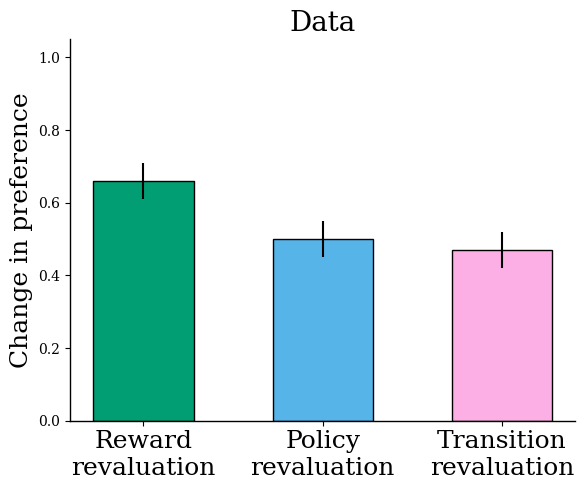

In [27]:
save_path = save_dir + "NHB_data.png"
nhb_means = [0.66, 0.50, 0.47]
nhb_stds = [0.05, 0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Change in preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data", y_lim=[0.0,1.05,1])

## SR-IS

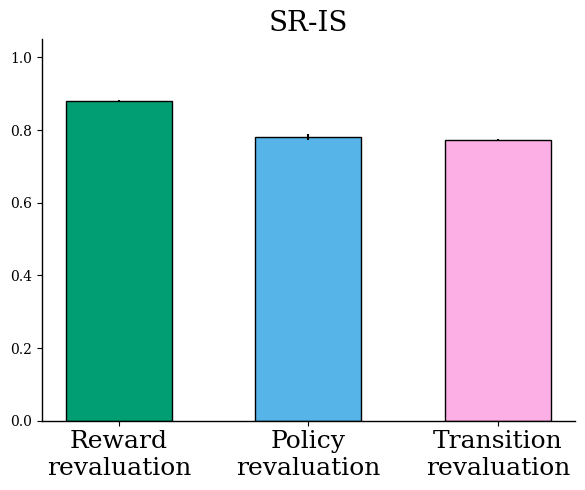

In [28]:
save_path = save_dir + "NHB_SR-IS.png"
means = [mean_reward_sr_is, mean_policy_sr_is, mean_transition_sr_is]
stds = [sem_reward_sr_is, sem_policy_sr_is, sem_transition_sr_is]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = None

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR-IS", y_lim=[0.0,1.05,1])

## SR

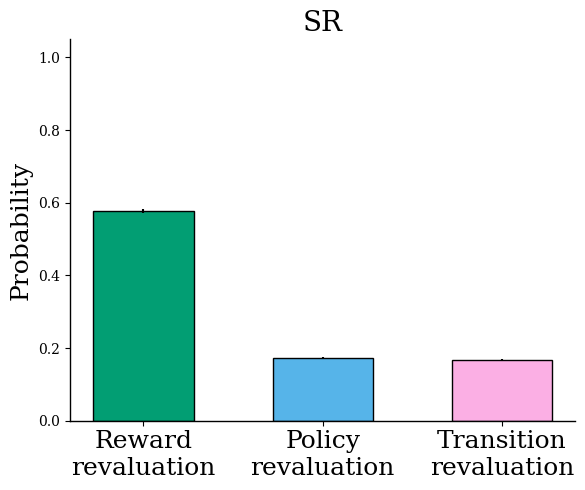

In [29]:
save_path = save_dir + "NHB_SR.png"
means = [mean_reward_sr, mean_policy_sr, mean_transition_sr]
stds = [sem_reward_sr, sem_policy_sr, sem_transition_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR", y_lim=[0.0,1.05,1])

## Linear RL Model

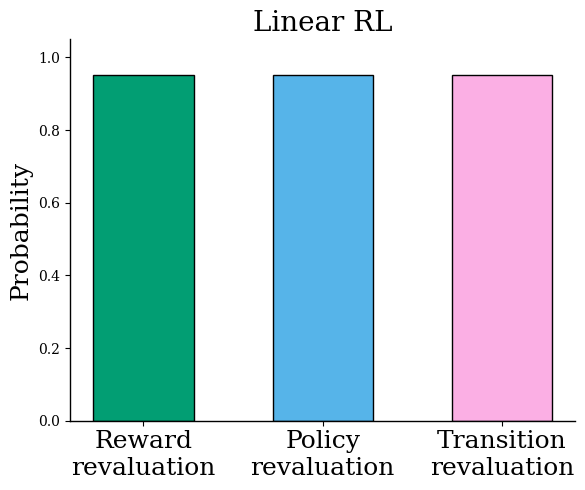

In [30]:
save_path = save_dir + "NHB_LRL.png"
means = [mean_reward_complete, mean_policy_complete, mean_transition_complete]
stds = [sem_reward_complete, sem_policy_complete, sem_transition_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Linear RL", y_lim=[0.0,1.05,1])

## MB Model

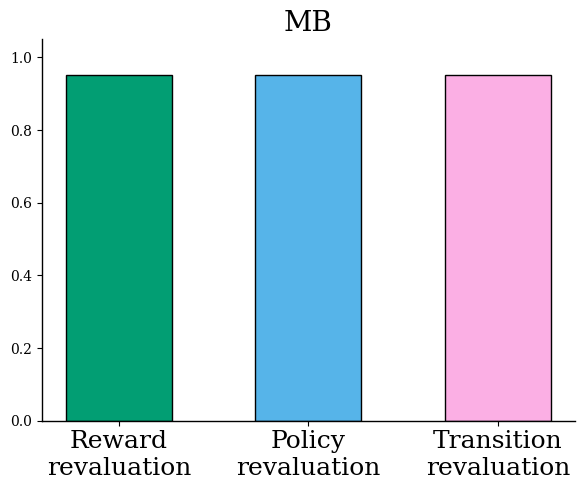

In [31]:
save_path = save_dir + "NHB_MB.png"
means = [mean_reward_mb, mean_policy_mb, mean_transition_mb]
stds = [sem_reward_mb, sem_policy_mb, sem_transition_mb]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = None

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="MB", y_lim=[0.0,1.05,1])

## Hybrid SR-MB Model

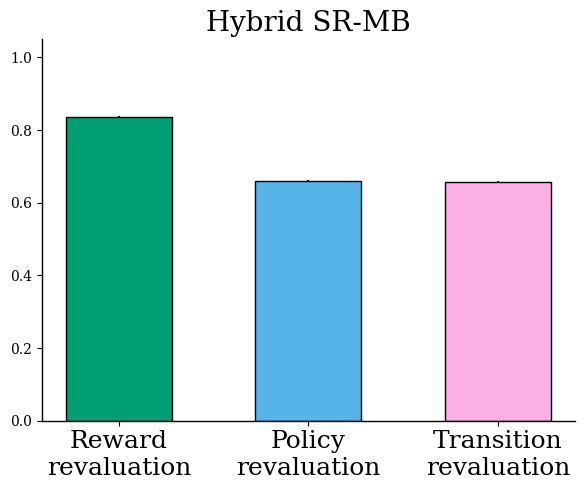

In [32]:
save_path = save_dir + "NHB_Hybrid.png"
means = [mean_reward_hybrid, mean_policy_hybrid, mean_transition_hybrid]
stds = [sem_reward_hybrid, sem_policy_hybrid, sem_transition_hybrid]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = None

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Hybrid SR-MB", y_lim=[0.0,1.05,1])

# Plot full values

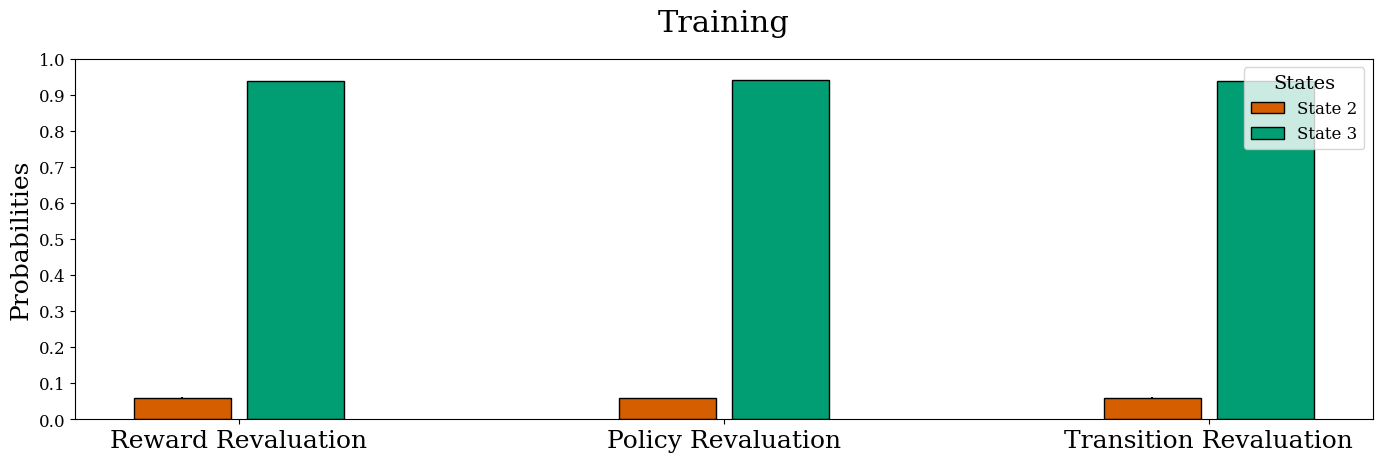

In [26]:
save_path = save_dir + "nhb_simulations_train.png"

plot_nhb_decisions(
    probs_reward=mean_reward_train,
    probs_policy=mean_policy_train,
    probs_transition=mean_transition_train,
    colors=colors,
    leg_loc='upper right',
    save_path=None,
    title='Training',
    std=[sem_reward_train, sem_policy_train, sem_transition_train]
)

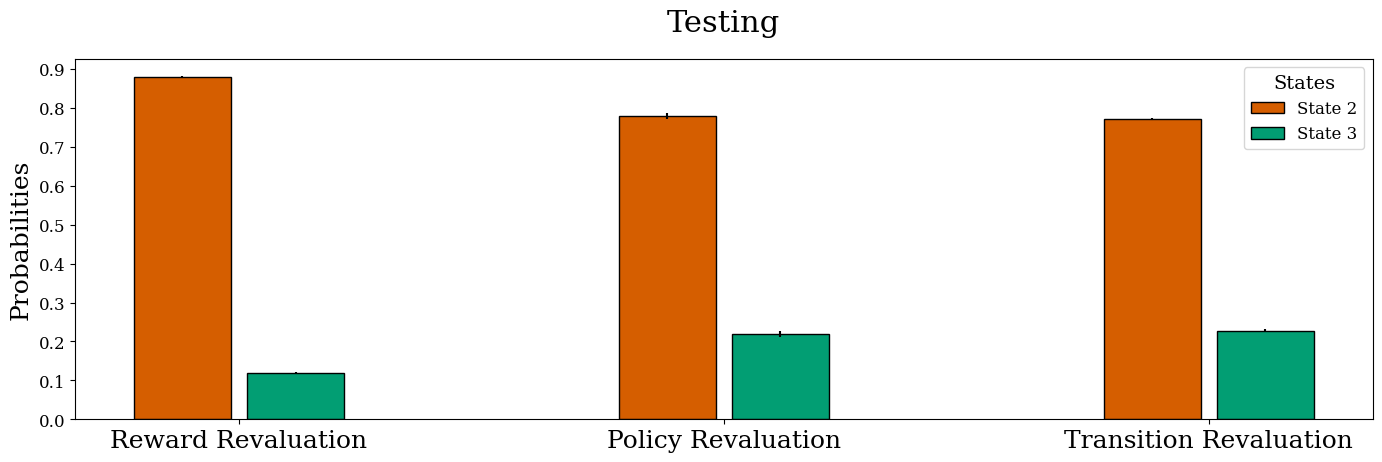

In [25]:
save_path = save_dir + "nhb_simulations_test.png"

plot_nhb_decisions(
    probs_reward=mean_reward_test,
    probs_policy=mean_policy_test,
    probs_transition=mean_transition_test,
    colors=colors,
    leg_loc='upper right',
    save_path=None,
    title='Testing',
    std=[sem_reward_test, sem_policy_test, sem_transition_test]
)